# Calculate CMIP Indeces

This file 
1. calculates all the indeces for all months for all cmip models.

    (a). use EC index for nino



In [1]:
import xarray
import numpy
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches


In [2]:
#import my functions
import utils._modelDefinitions as _model
import utils._indexDefinitions as _index
import utils.sstIndex as sst
import utils.pslIndex as psl
import utils.timePeriod as tp
import utils.compound as compound
import utils.ecIndex as ec
import utils.overlapBins as overlapBins


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
modelSet=_model.scenarioMip

In [5]:
experimentSet=_model.experimentSet

In [6]:
nino34Domain=_index.sstIndex['nino34']

nino34Domain

{'latMin': -5, 'latMax': 5, 'longMin': 190, 'longMax': 240}

In [7]:
#figure out where to plot nino34 box on anomaly plots
mapCentre=210
nino34Box={
    'xy':[nino34Domain['longMin']-mapCentre, nino34Domain['latMin']],
    'width':nino34Domain['longMax']-nino34Domain['longMin'],
    'height':nino34Domain['latMax']-nino34Domain['latMin']
}

nino34Box

{'xy': [-20, -5], 'width': 50, 'height': 10}

# 1. Calculate CMIP Indeces

For each experiment in historical, calculate indices

#The heavy lifting - you need the output from this to proceed

%run ./cmipECIndeces.py

In [8]:
multipliers={
    'ACCESS-CM2':[-1,1], 
    'ACCESS-ESM1-5':[1,-1],
    'AWI-CM-1-1-MR':[-1,-1],
    'BCC-CSM2-MR':[1,-1],
    'CAMS-CSM1-0':[-1,-1],
    'CAS-ESM2-0':[-1,1],
    'CESM2':[-1,-1], 
    'CESM2-WACCM':[-1,-1],
    'CIESM':[-1,1], 
    'CMCC-CM2-SR5':[1,1],
    'CMCC-ESM2':[-1,-1], 
    'CNRM-CM6-1':[-1,1], 
    'CNRM-ESM2-1':[-1,-1], 
    'CanESM5':[-1,-1],
    'CanESM5-CanOE':[1,-1], 
    'EC-Earth3':[-1,-1], 
    'EC-Earth3-CC':[-1,-1], 
    'EC-Earth3-Veg':[-1,1],
    'EC-Earth3-Veg-LR':[-1,1], 
    'FIO-ESM-2-0':[1,-1],
    'GFDL-CM4':[-1,-1], 
    'GFDL-ESM4':[-1,-1], 
    'GISS-E2-1-G':[-1,1],
    'HadGEM3-GC31-LL':[-1,-1], 
    'HadGEM3-GC31-MM':[1,-1], 
    'INM-CM4-8':[-1,1], 
    'INM-CM5-0':[1,1],
    'IPSL-CM6A-LR':[1,1], 
    'MCM-UA-1-0':[1,1], 
    'MIROC-ES2L':[1,1], 
    'MIROC6':[1,-1],
    'MPI-ESM1-2-HR':[1,1], 
    'MPI-ESM1-2-LR':[1,-1],
    'MRI-ESM2-0':[-1,1], 
    'NESM3':[1,-1],
    'NorESM2-LM':[1,-1], 
    'NorESM2-MM':[-1,-1], 
    'UKESM1-0-LL':[-1,-1] 
    }

ACCESS-CM2
[-1, 1]


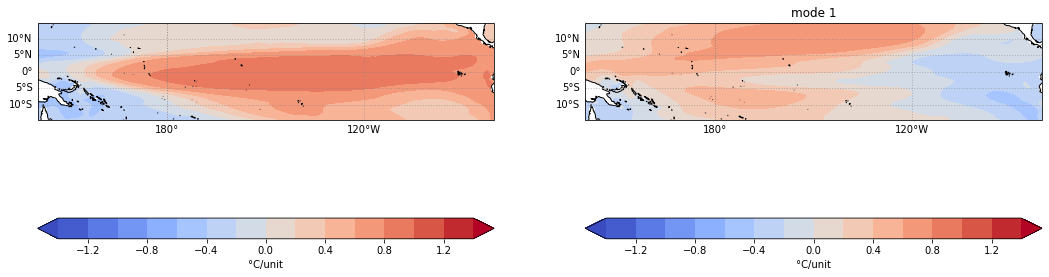

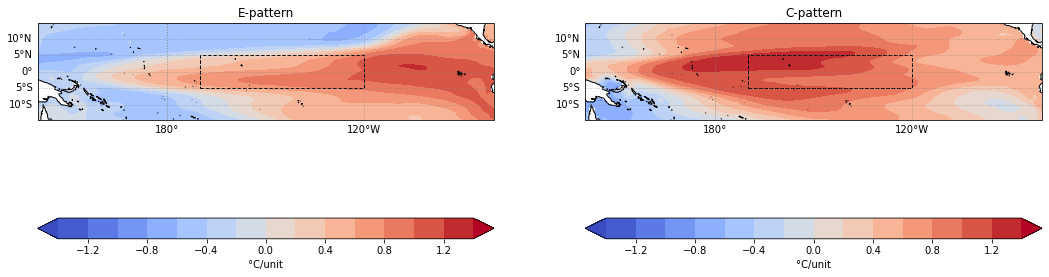

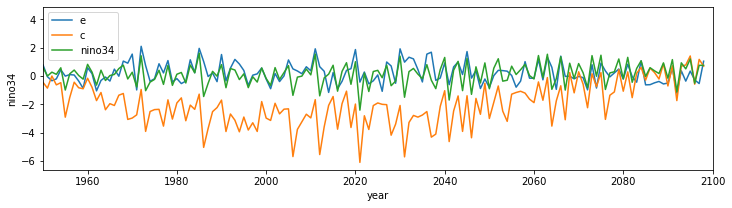

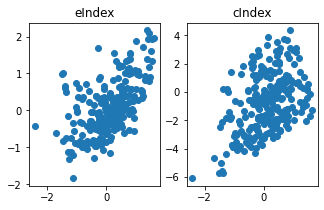

ACCESS-ESM1-5
[1, -1]


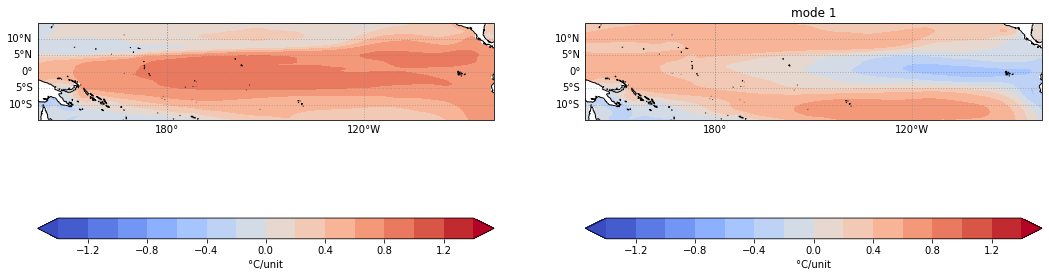

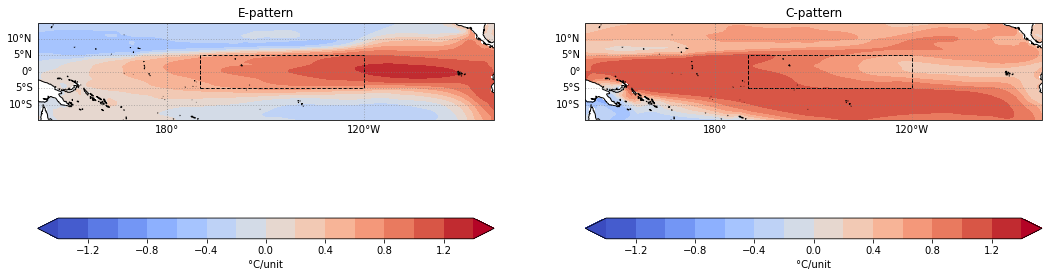

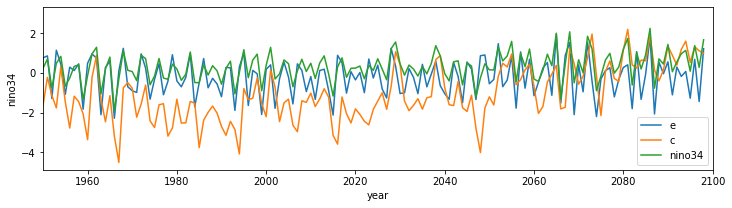

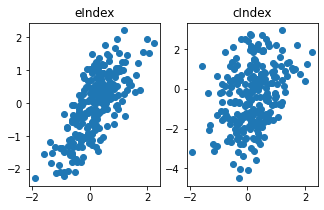

AWI-CM-1-1-MR
[-1, -1]
Cannot print patterns
Input z must be 2D, not 1D


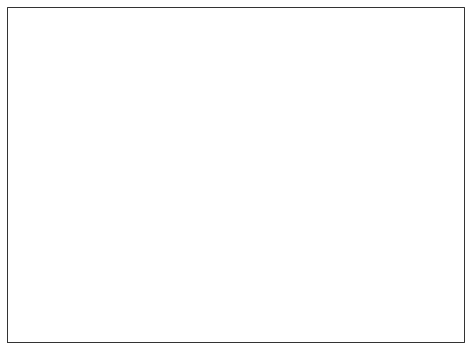

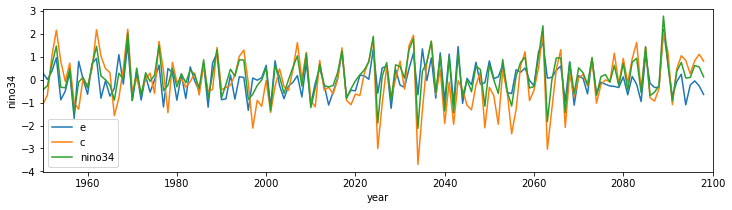

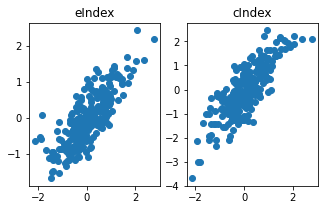

BCC-CSM2-MR
[1, -1]


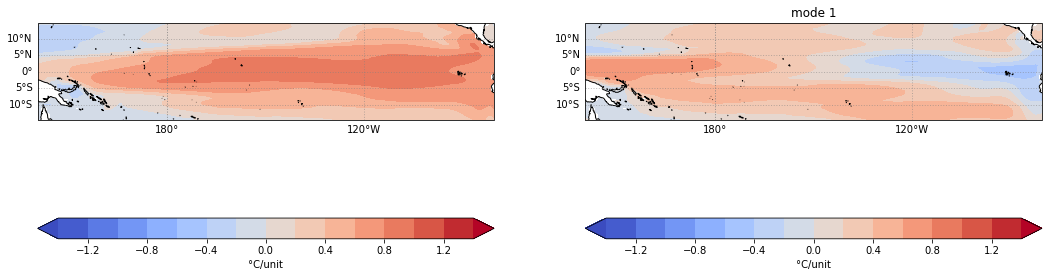

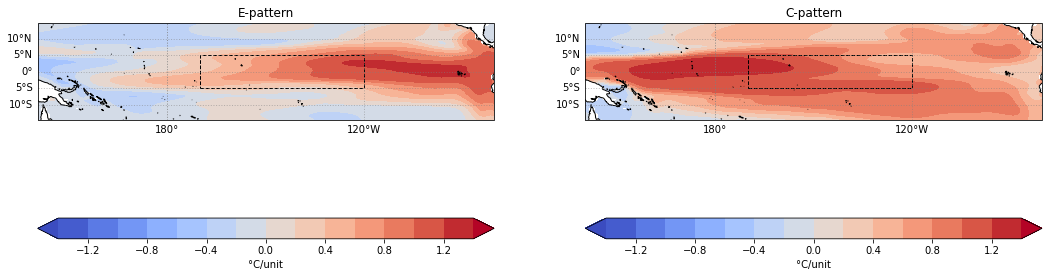

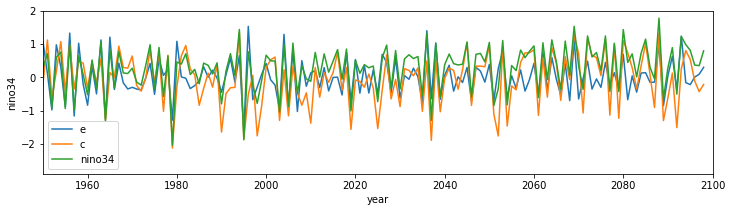

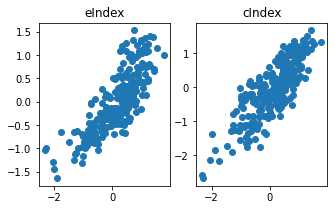

CAMS-CSM1-0
[-1, -1]


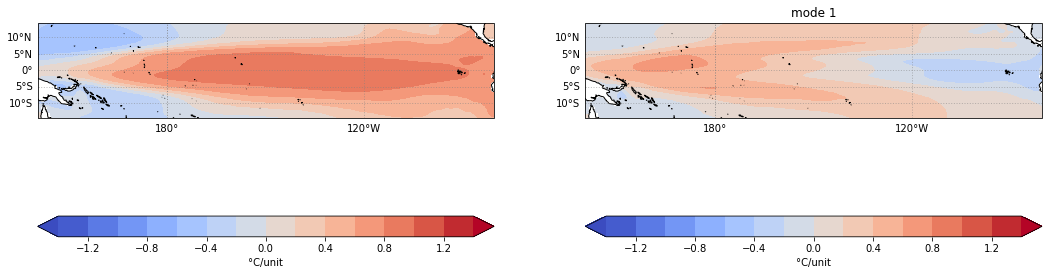

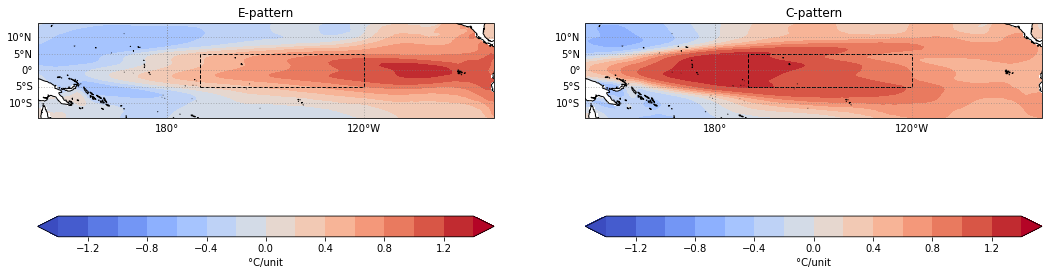

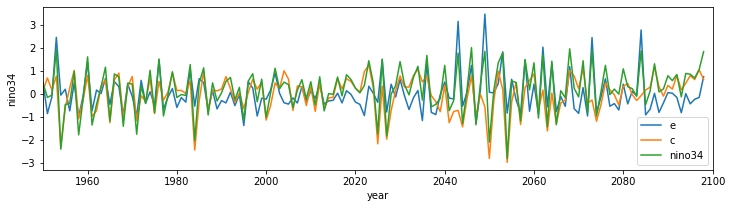

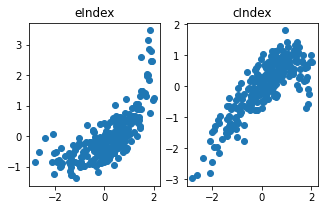

CAS-ESM2-0
[-1, 1]


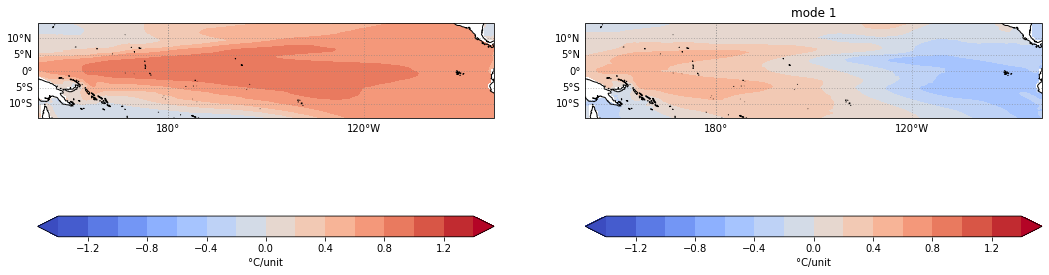

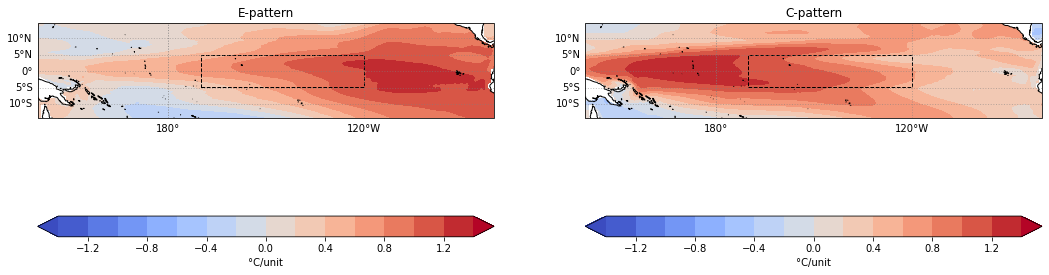

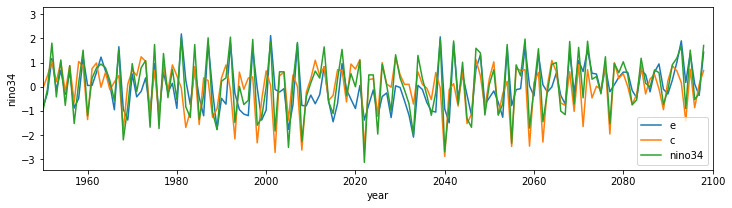

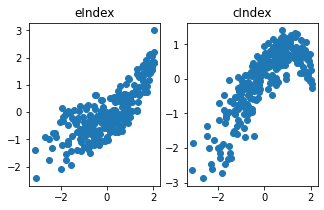

CESM2
[-1, -1]


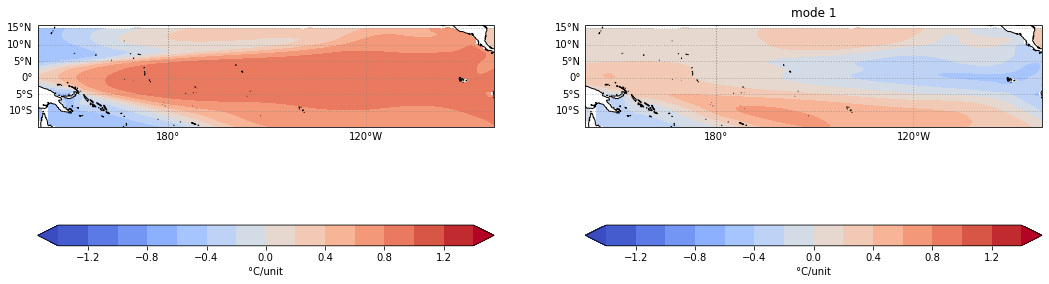

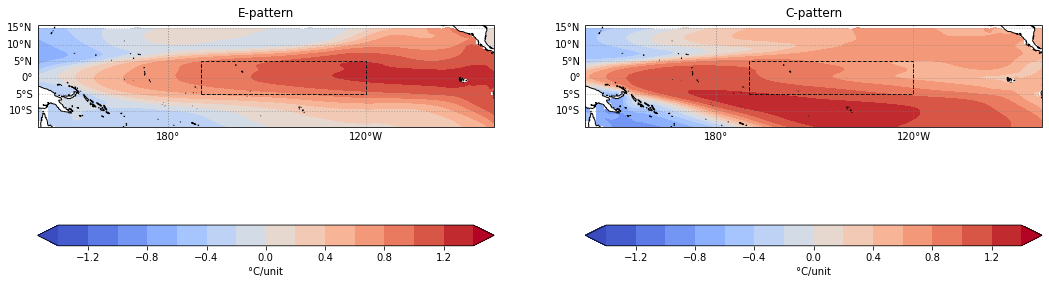

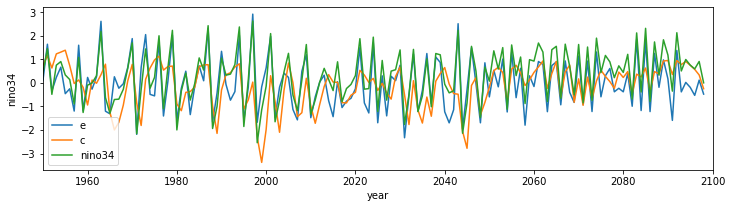

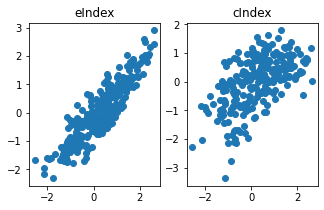

CESM2-WACCM
[-1, -1]


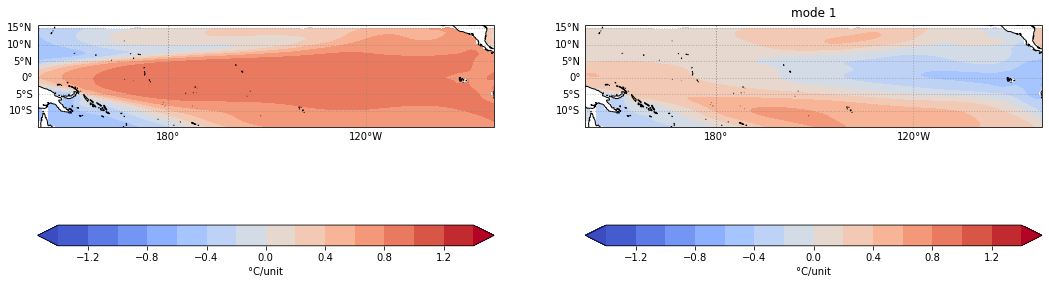

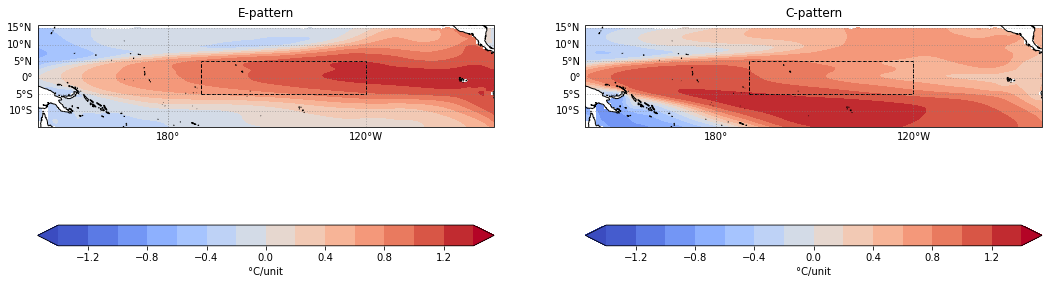

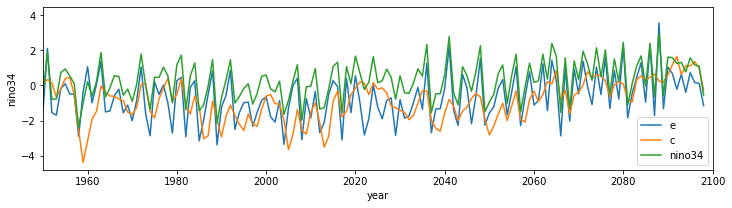

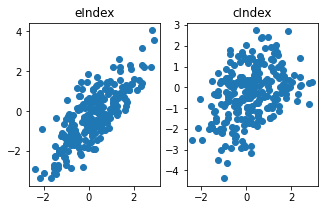

CIESM
[-1, 1]


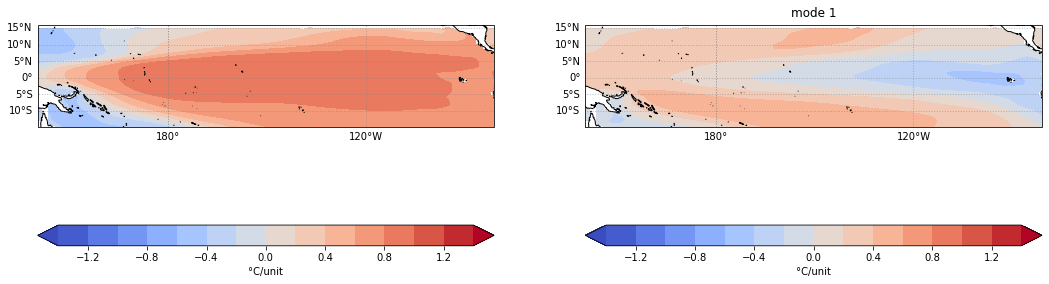

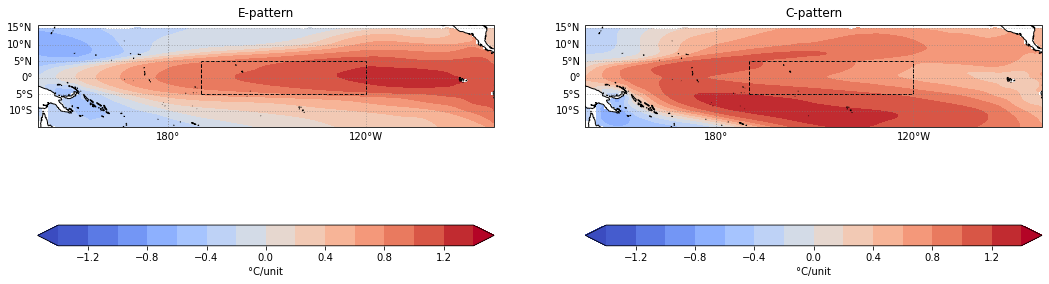

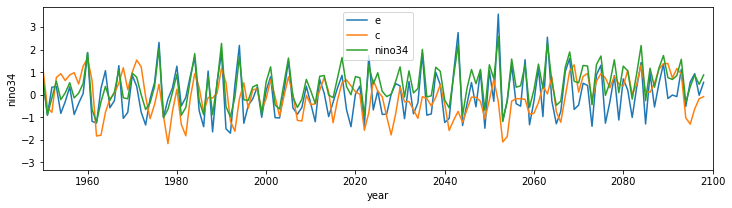

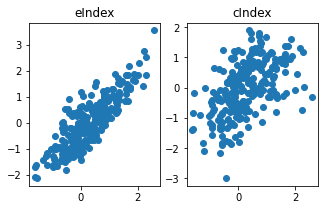

CMCC-CM2-SR5
[1, 1]


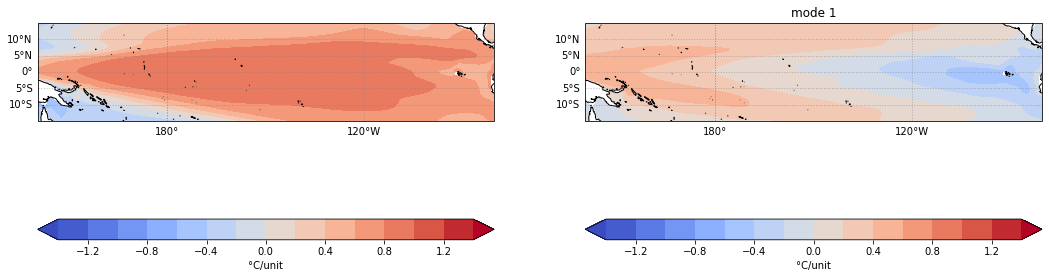

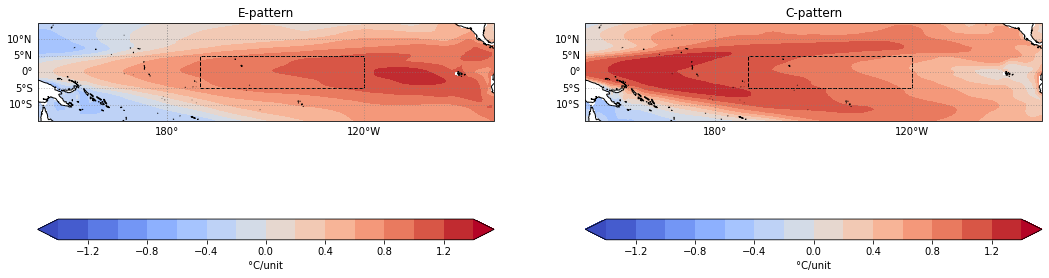

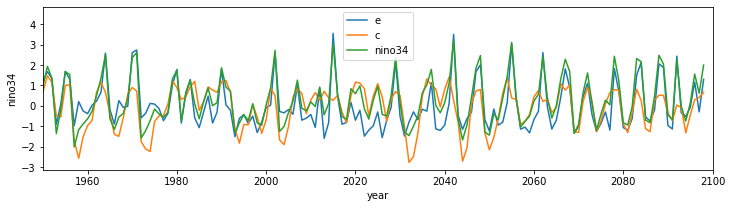

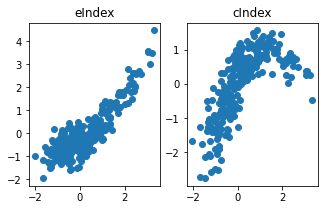

CMCC-ESM2
[-1, -1]


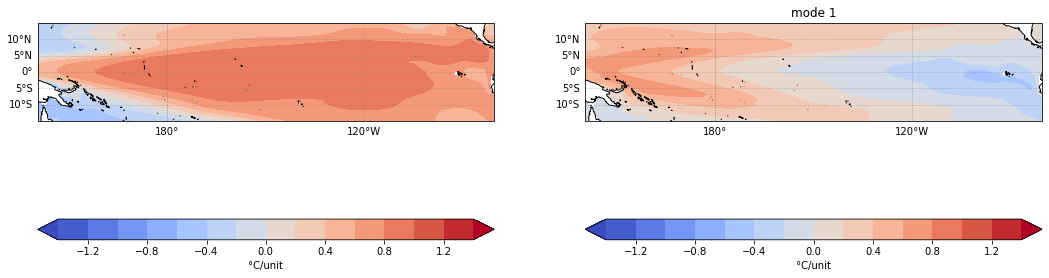

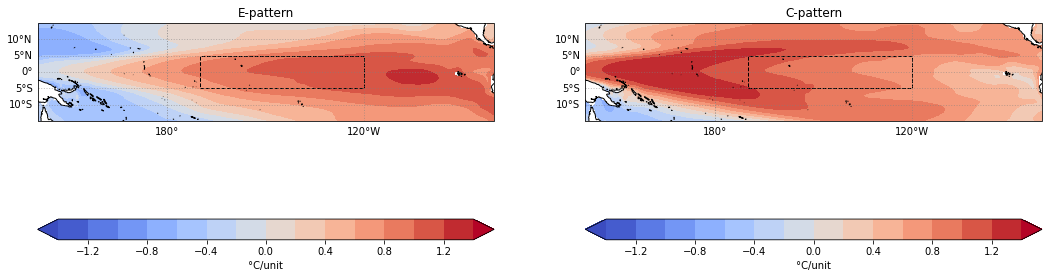

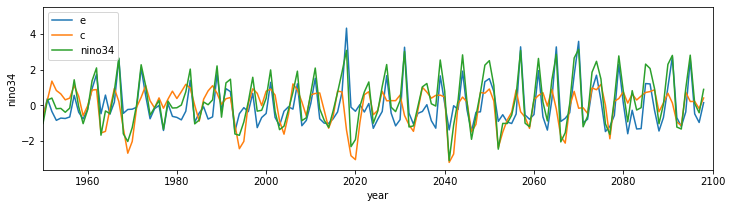

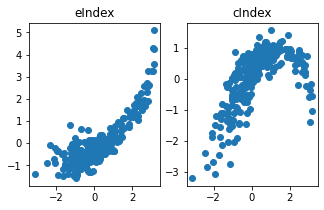

CNRM-CM6-1
[-1, 1]


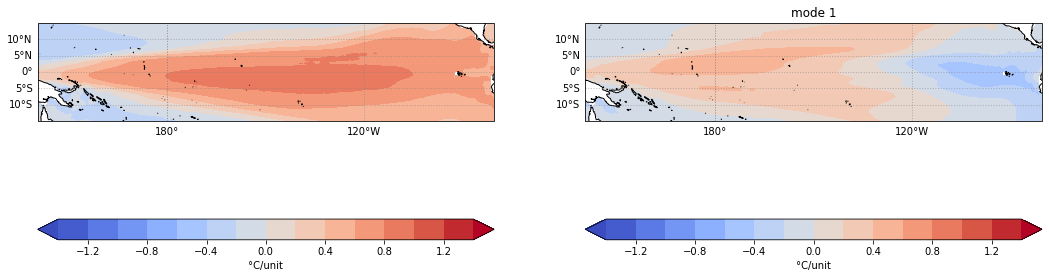

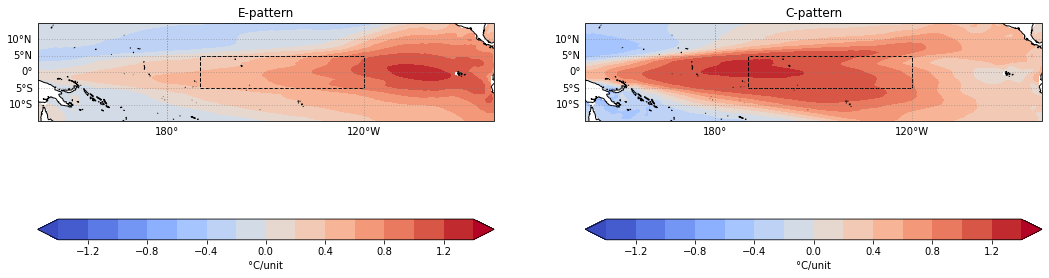

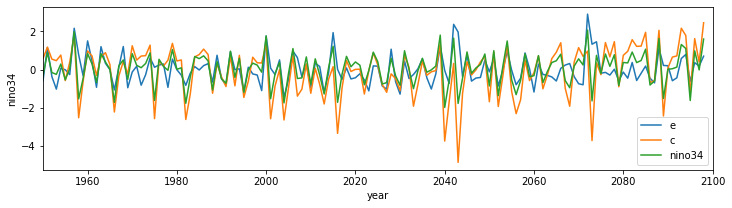

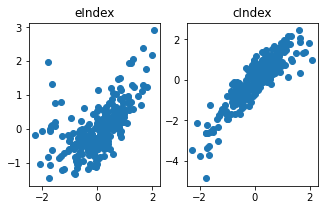

CNRM-ESM2-1
[-1, -1]


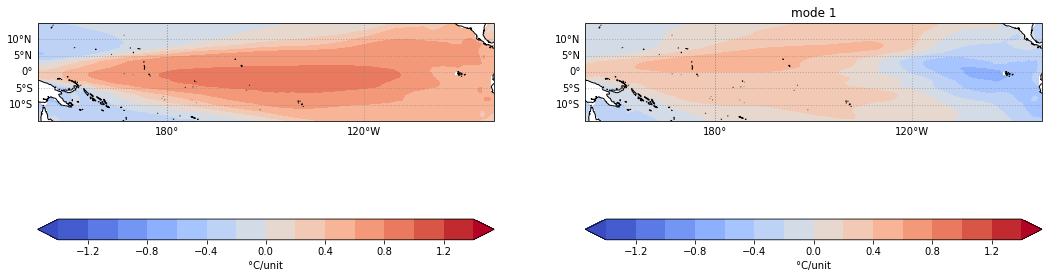

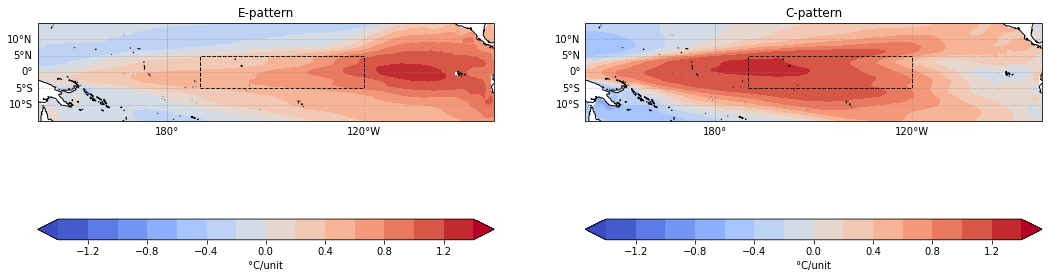

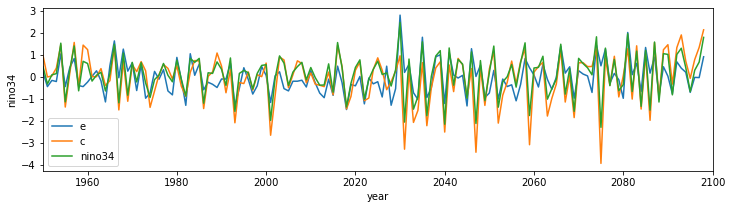

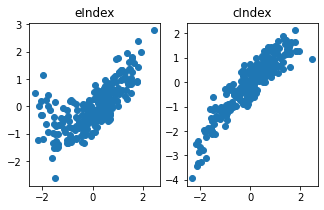

CanESM5
[-1, -1]


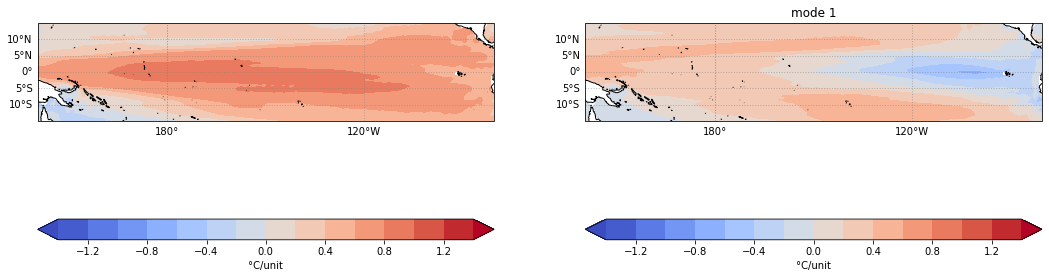

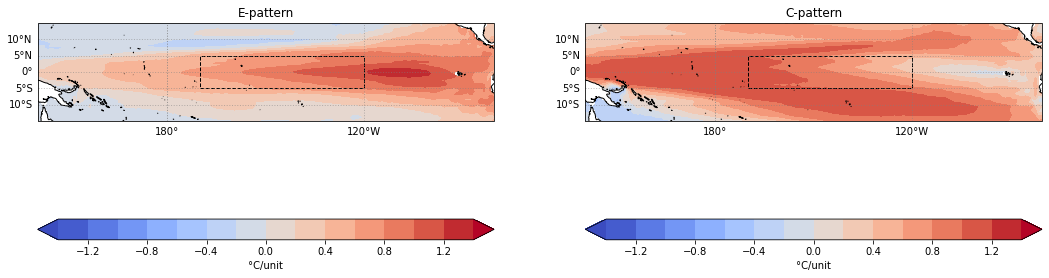

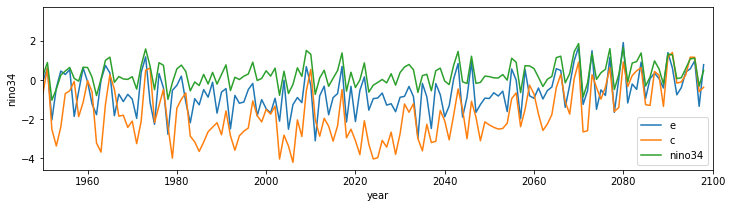

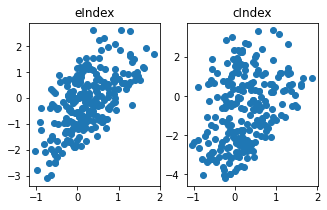

CanESM5-CanOE
[1, -1]


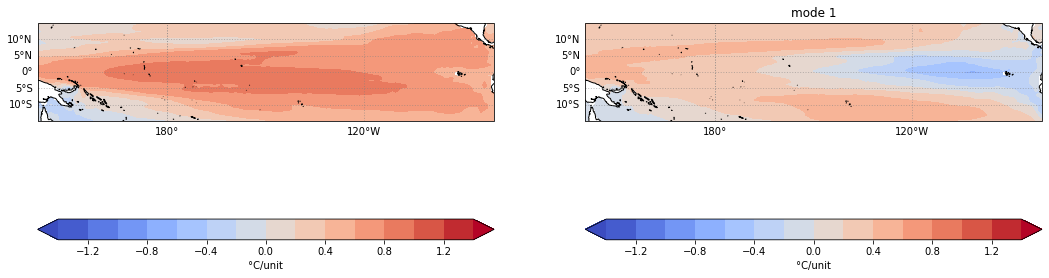

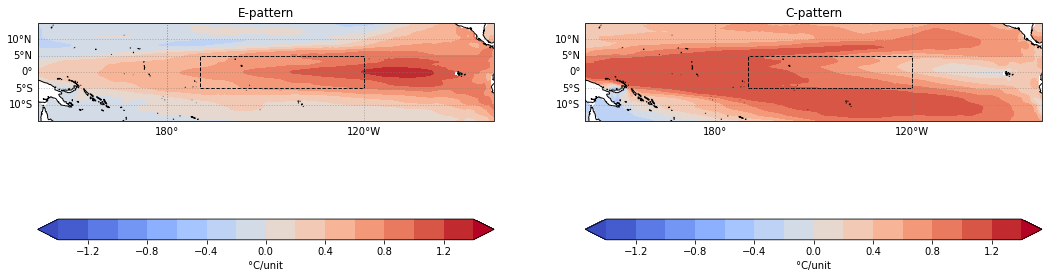

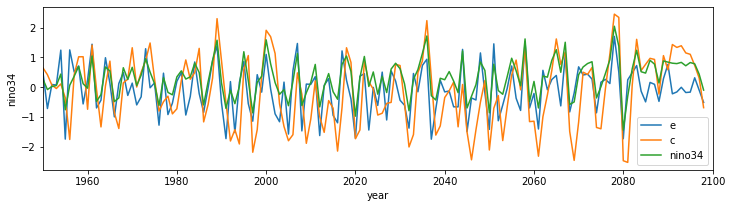

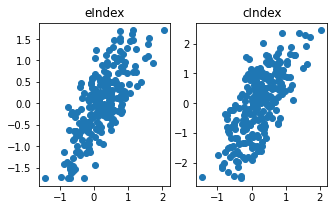

EC-Earth3
[-1, -1]


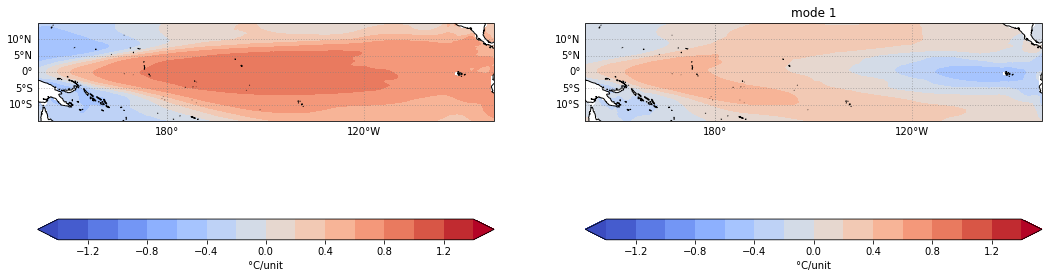

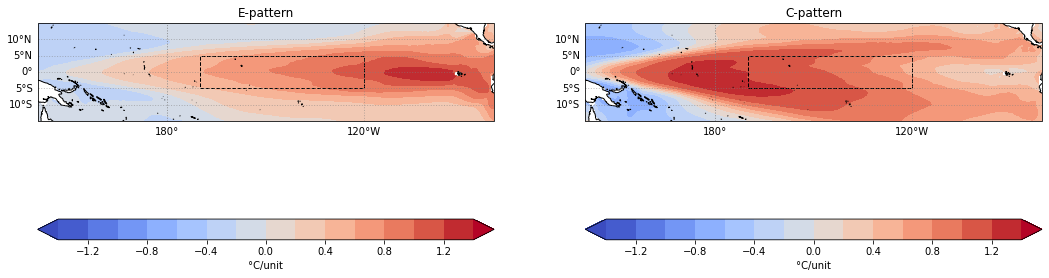

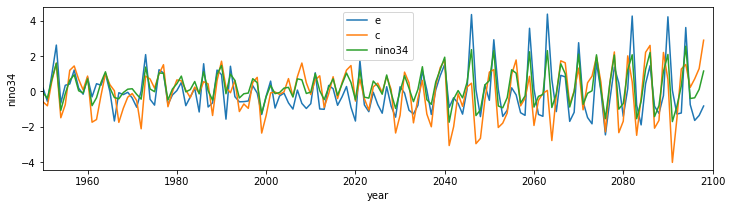

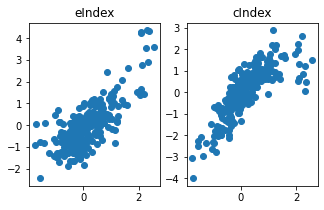

EC-Earth3-CC
[-1, -1]


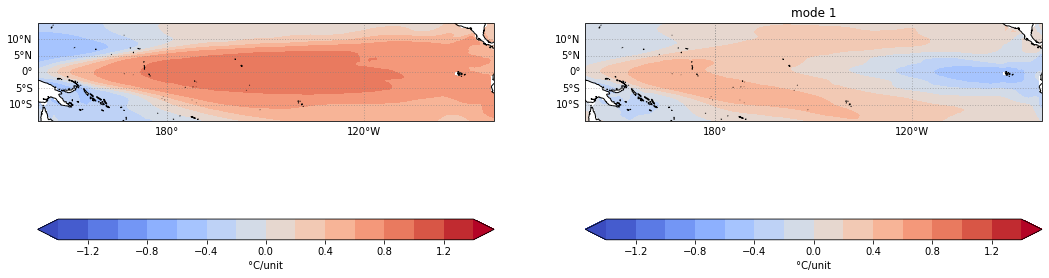

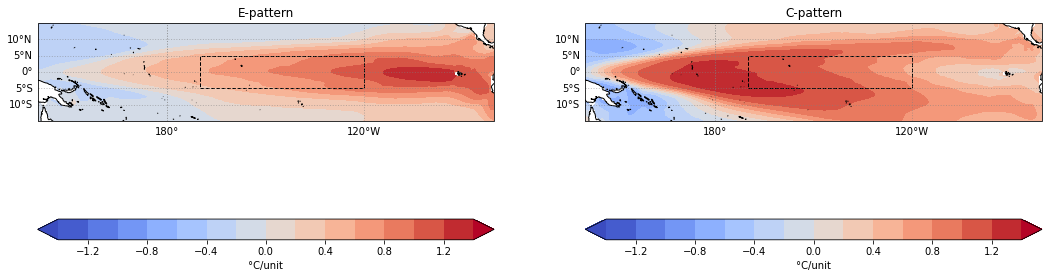

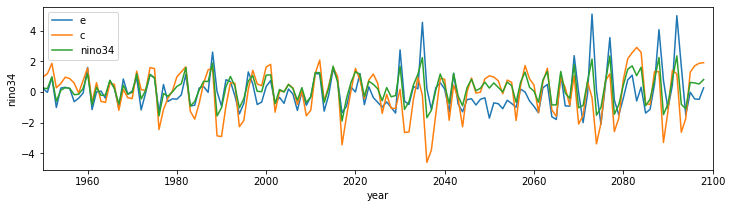

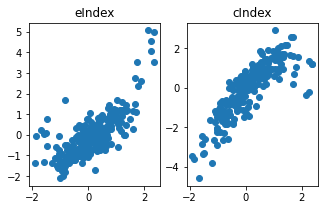

EC-Earth3-Veg
[-1, 1]


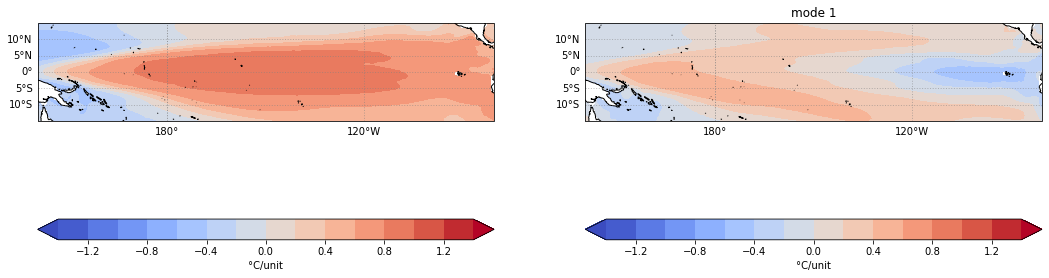

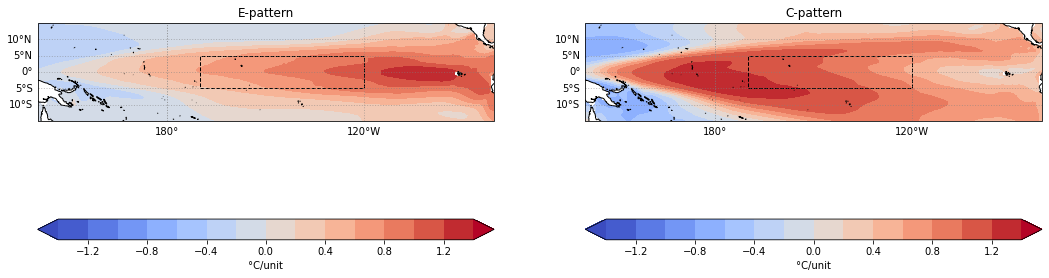

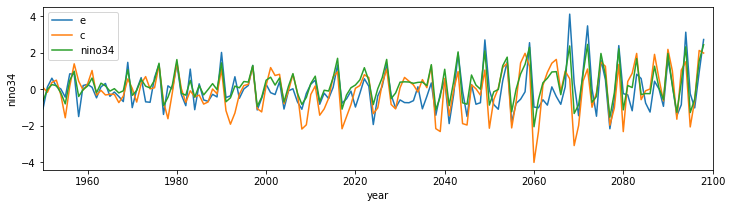

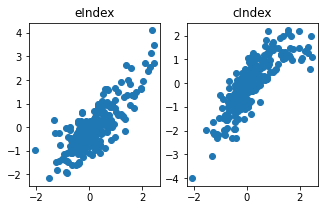

EC-Earth3-Veg-LR
[-1, 1]


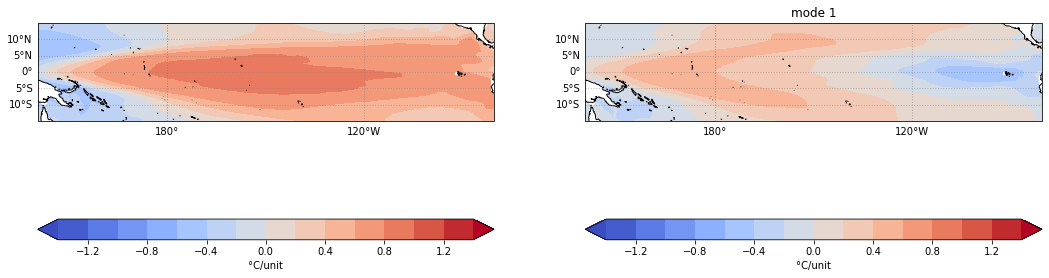

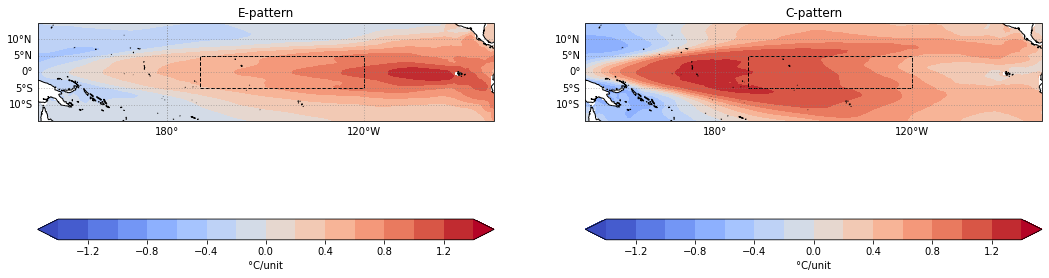

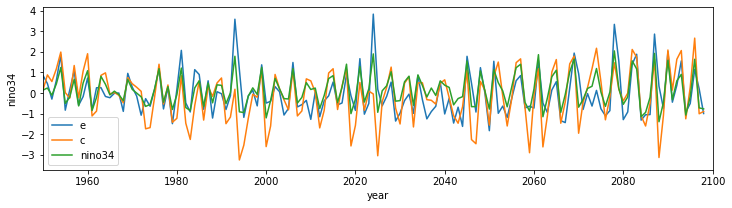

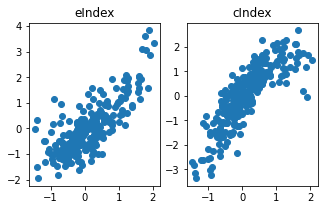

FIO-ESM-2-0
[1, -1]


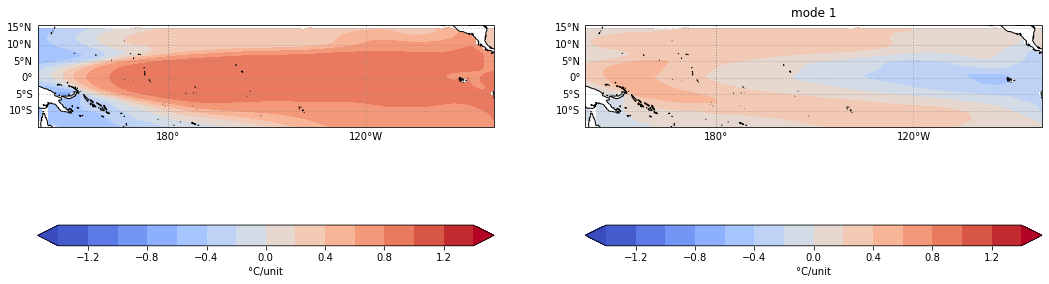

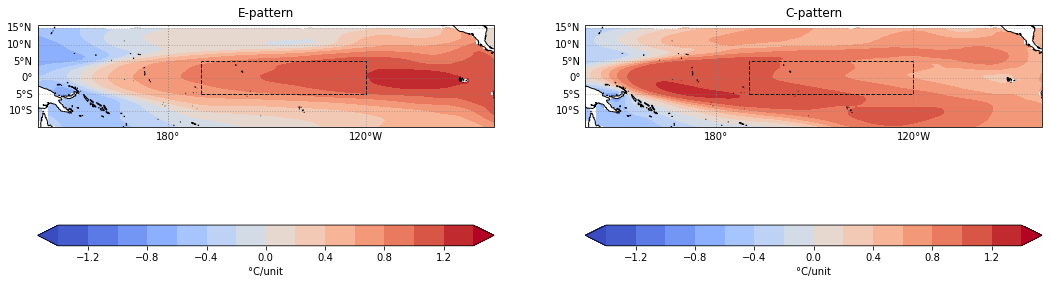

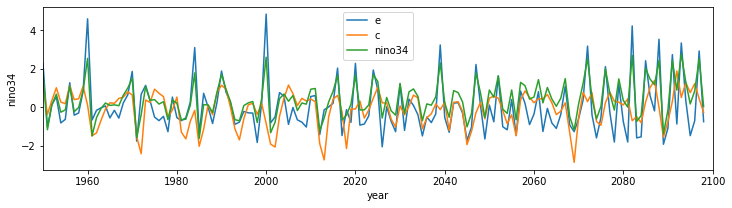

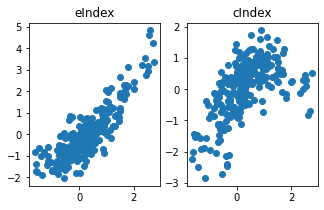

GFDL-CM4
[-1, -1]


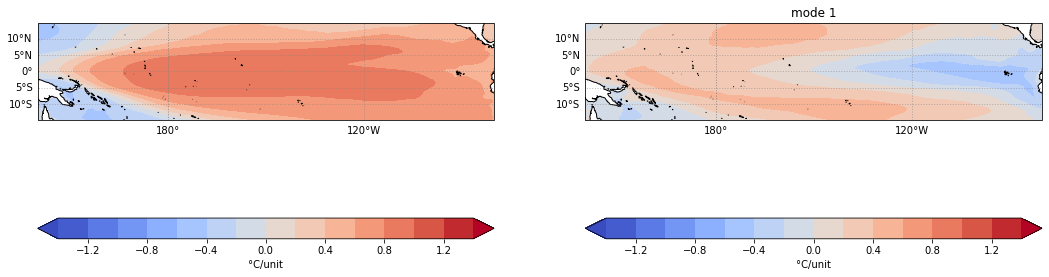

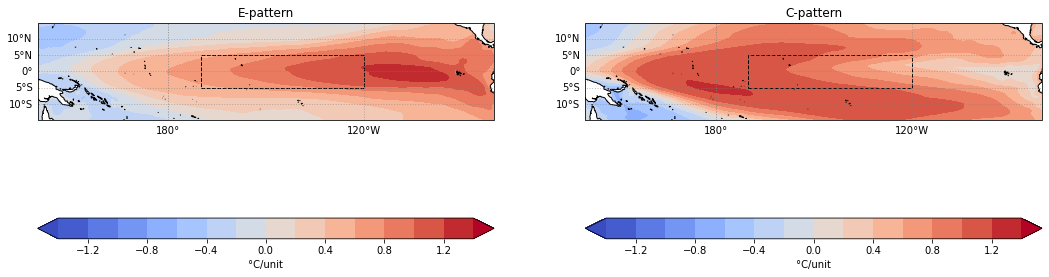

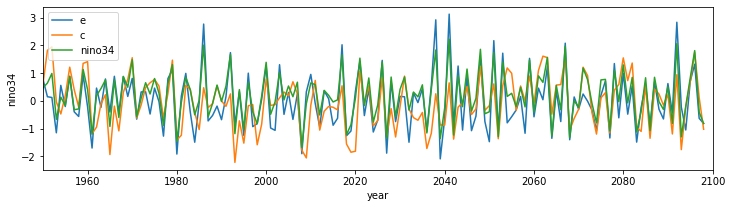

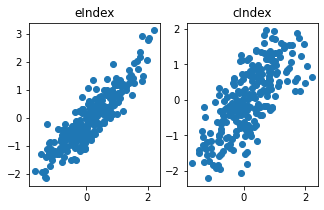

GFDL-ESM4
[-1, -1]


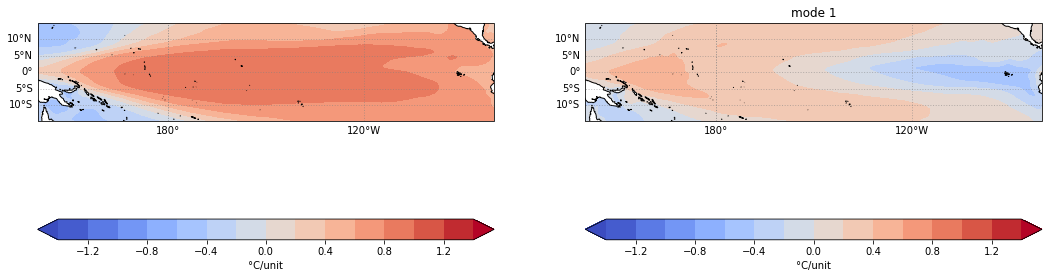

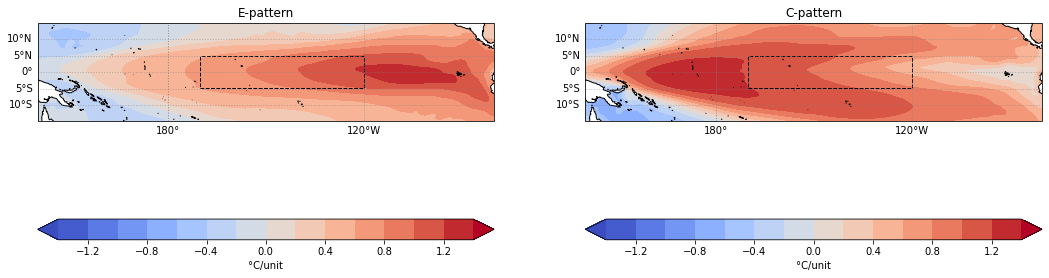

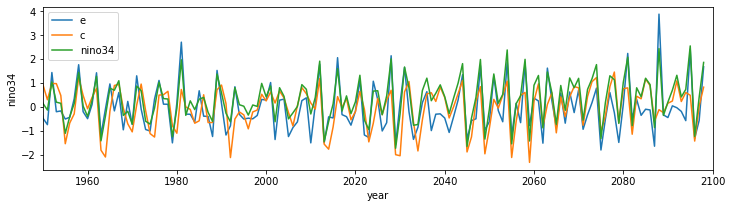

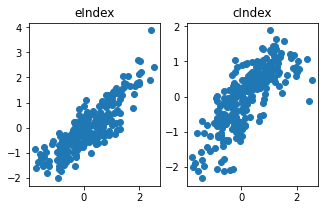

GISS-E2-1-G
[-1, 1]


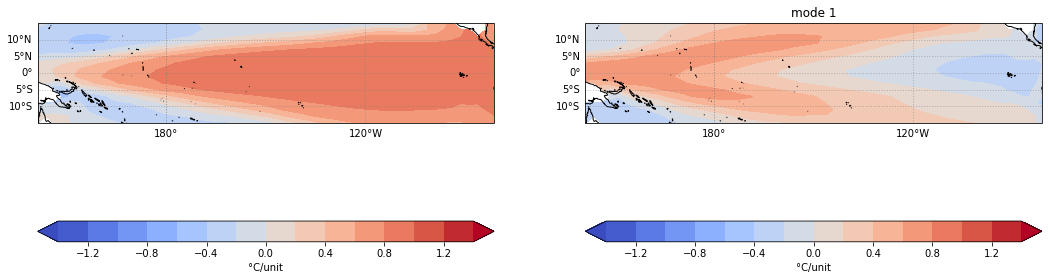

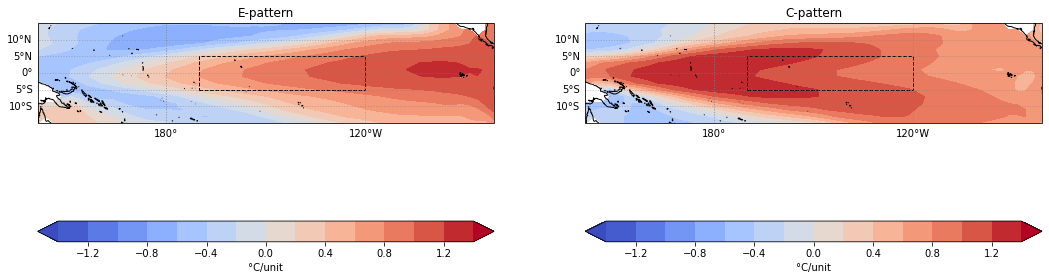

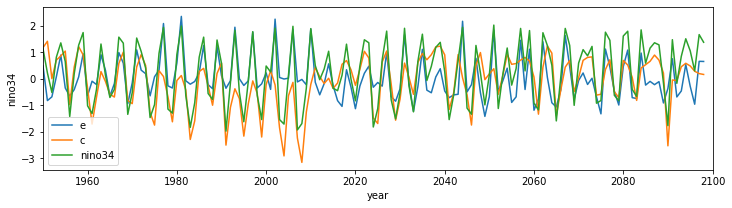

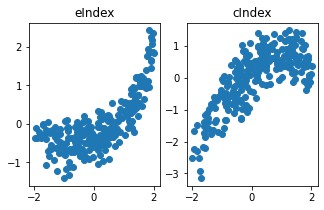

HadGEM3-GC31-LL
[-1, -1]


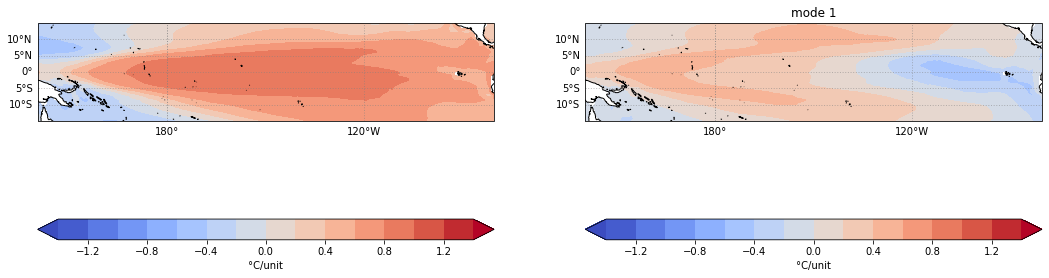

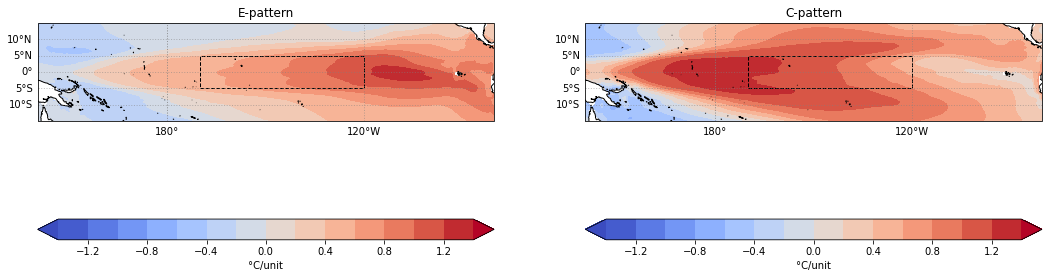

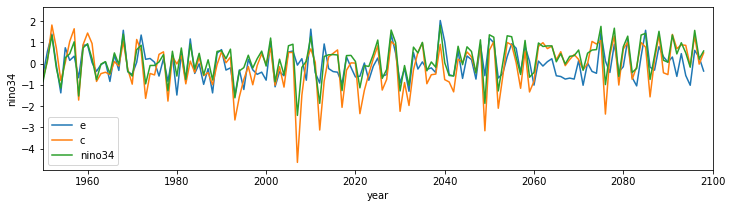

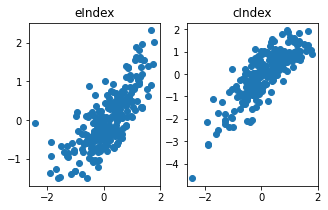

HadGEM3-GC31-MM
[1, -1]


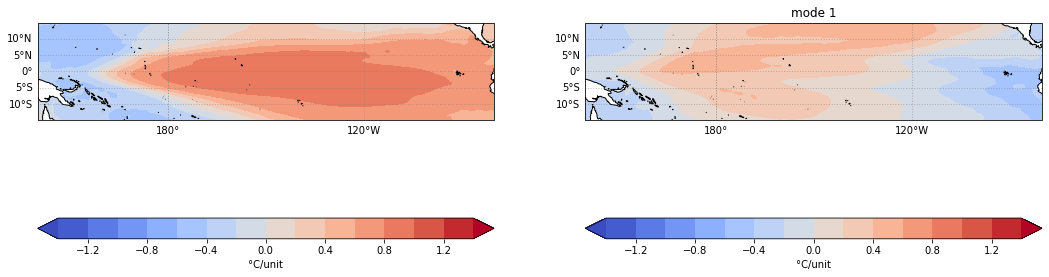

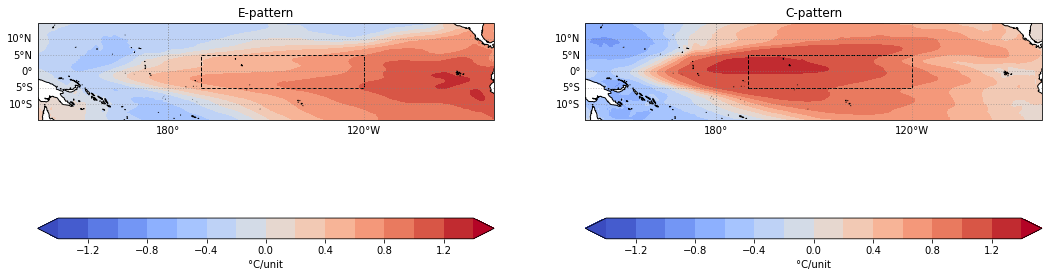

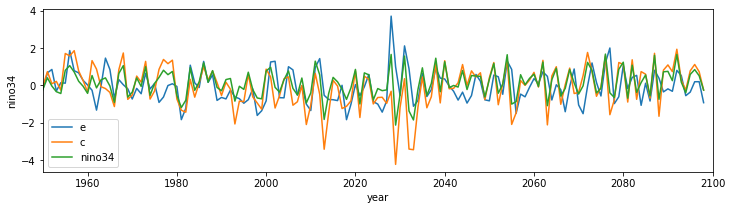

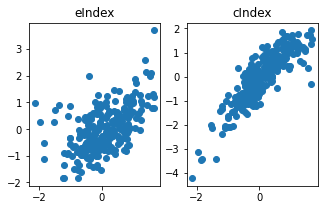

INM-CM4-8
[-1, 1]


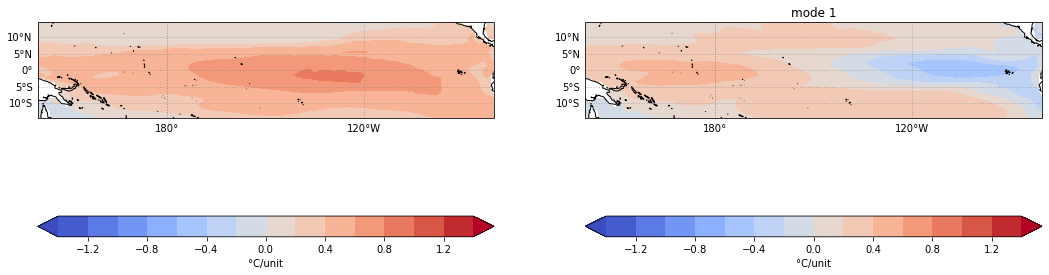

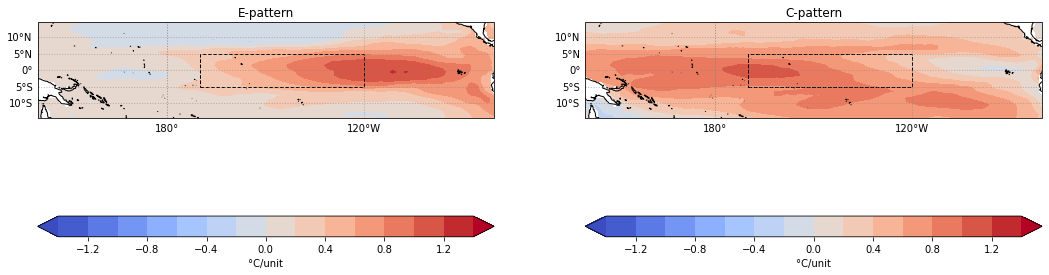

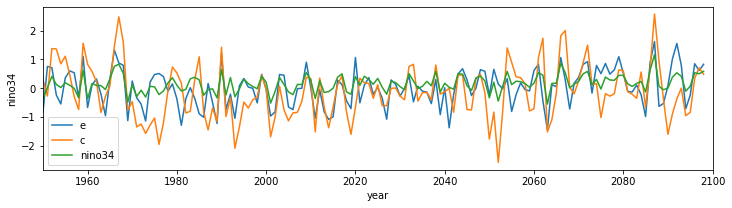

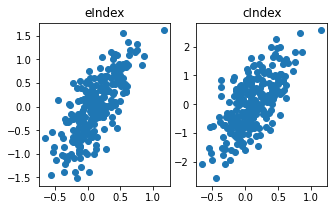

INM-CM5-0
[1, 1]


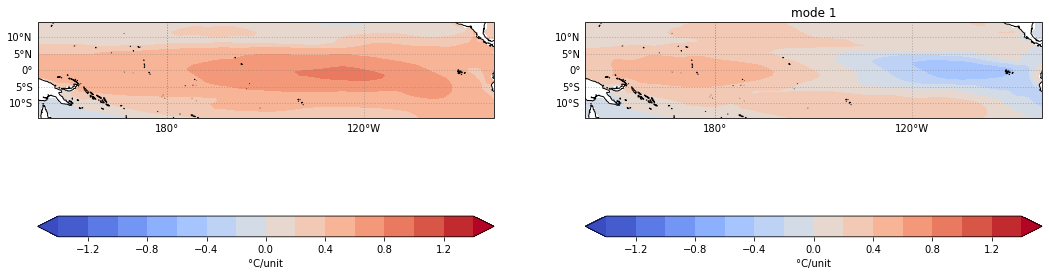

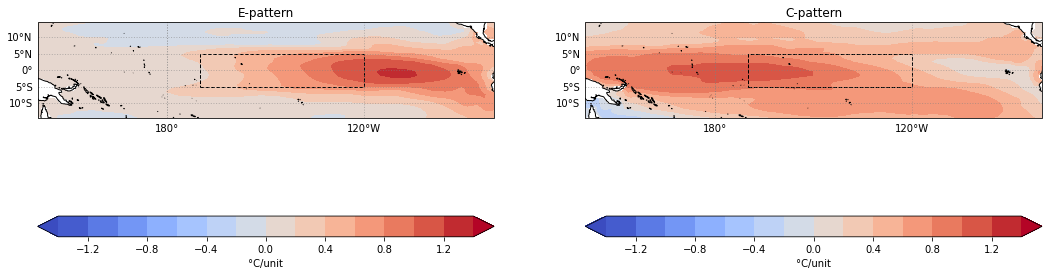

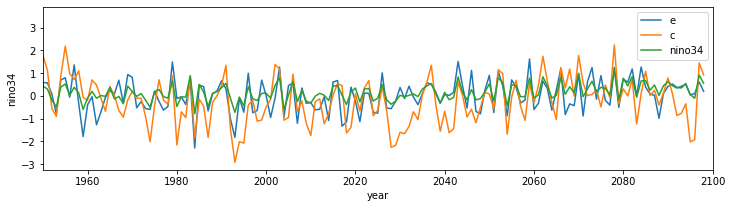

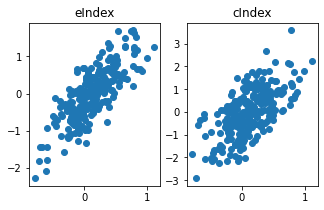

IPSL-CM6A-LR
[1, 1]


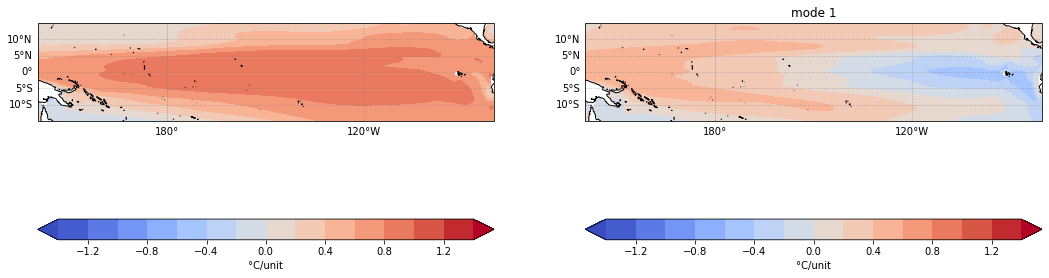

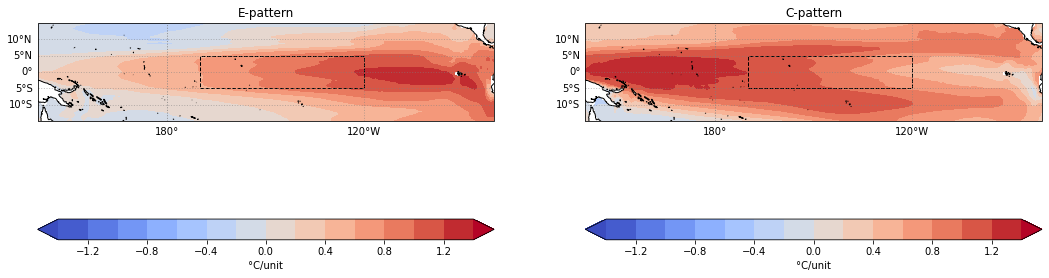

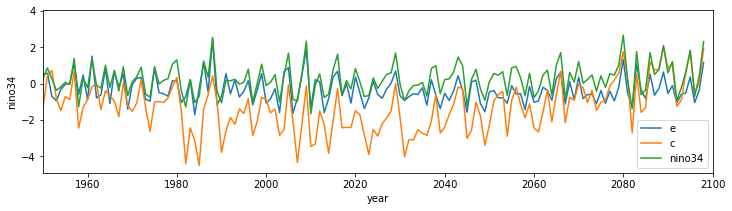

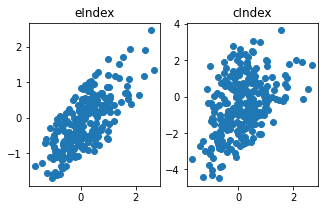

MCM-UA-1-0
[1, 1]


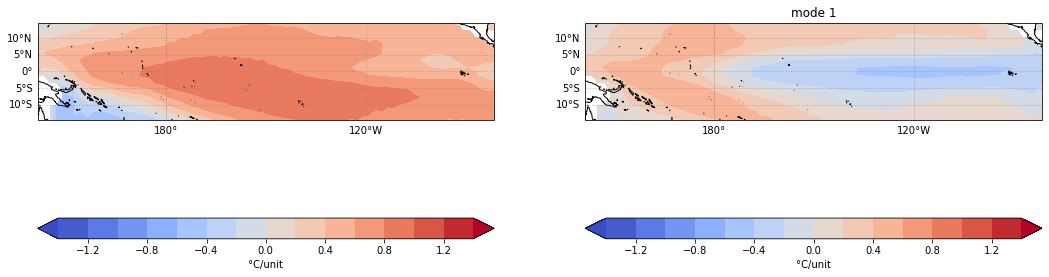

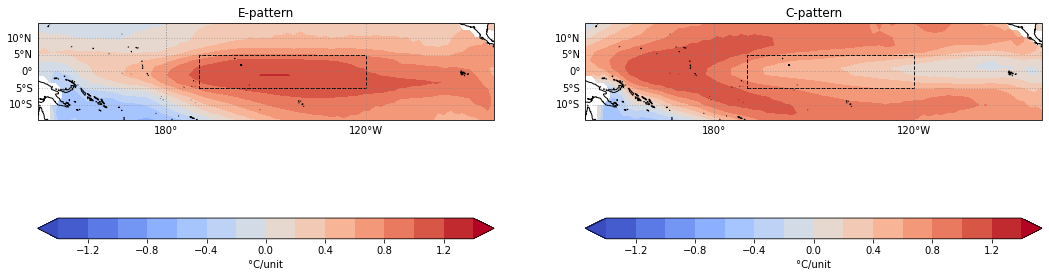

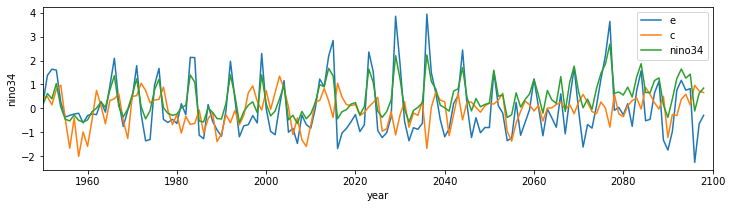

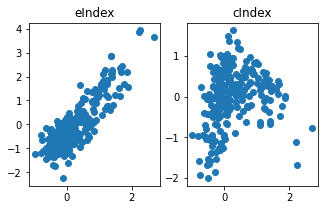

MIROC-ES2L
[1, 1]


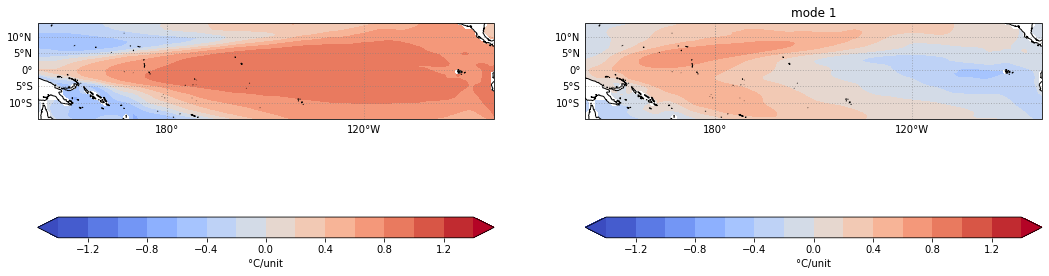

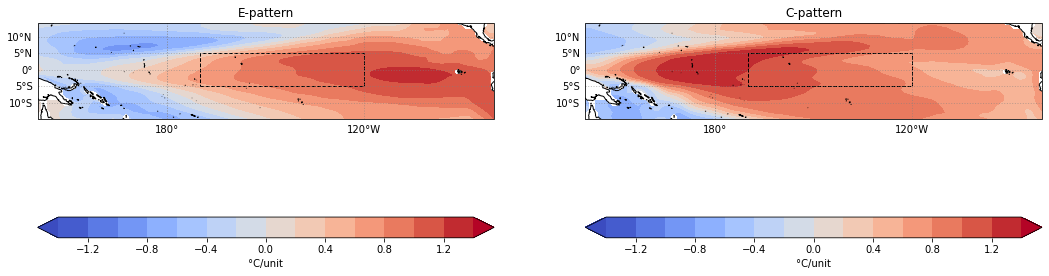

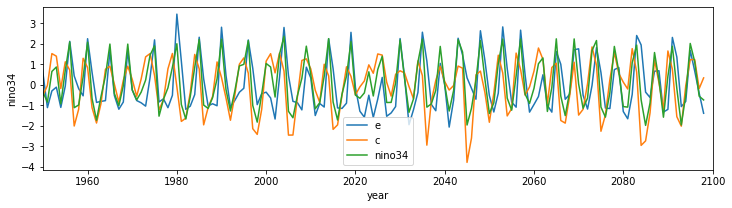

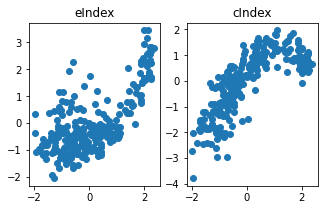

MIROC6
[1, -1]


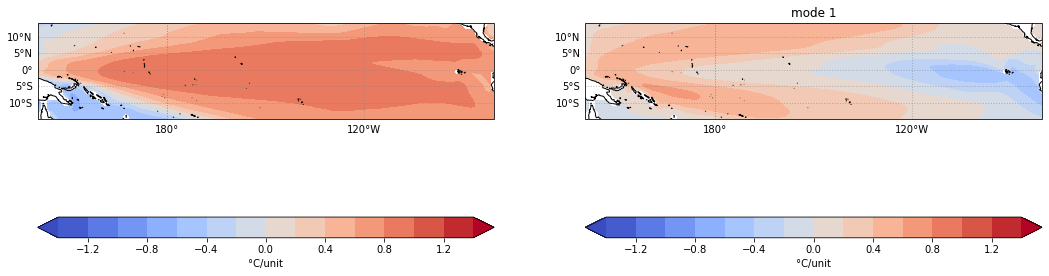

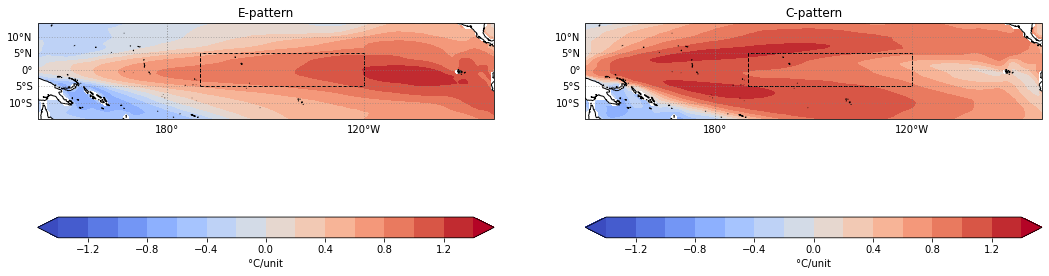

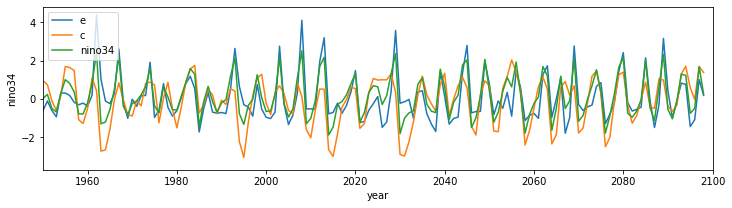

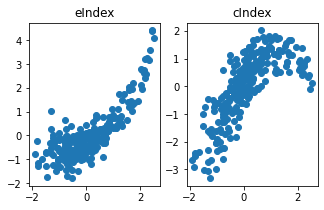

MPI-ESM1-2-HR
[1, 1]


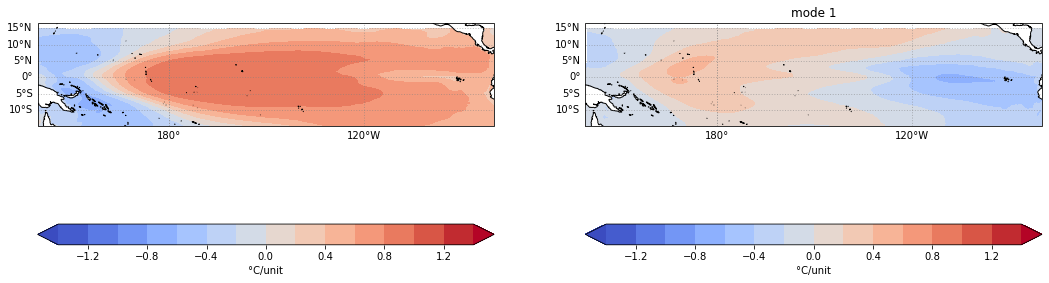

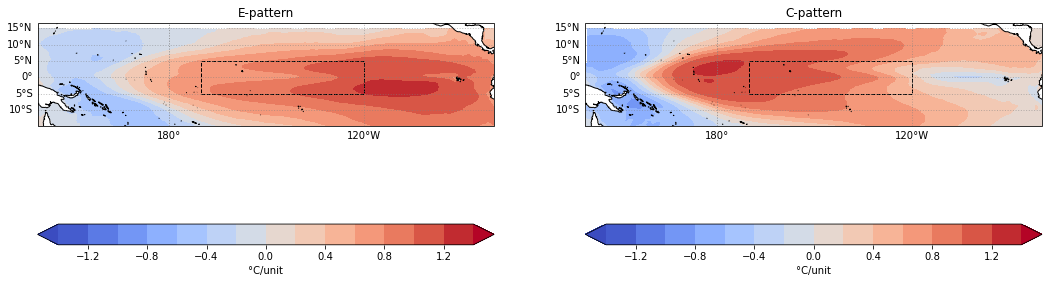

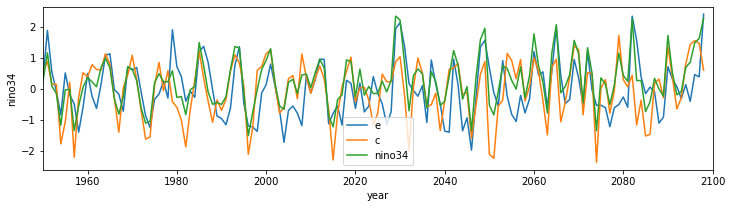

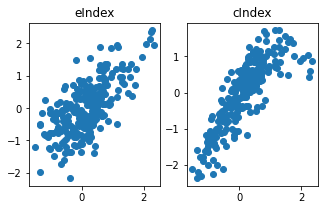

MPI-ESM1-2-LR
[1, -1]


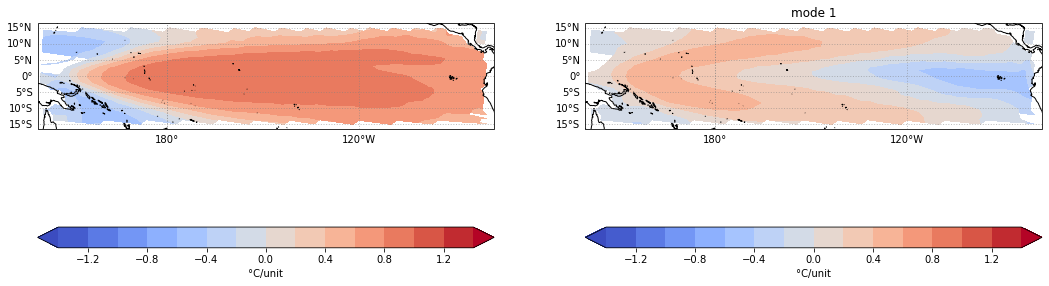

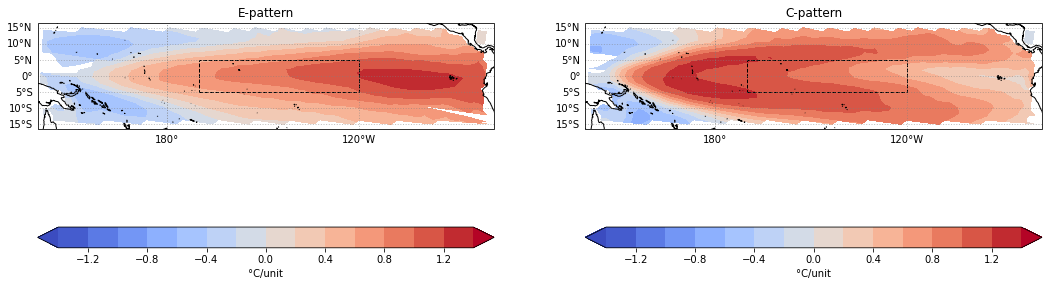

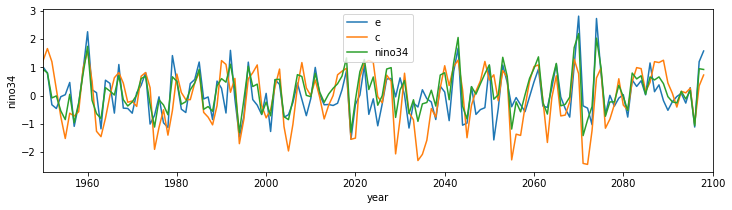

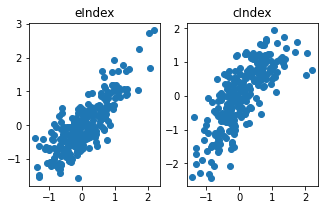

MRI-ESM2-0
[-1, 1]


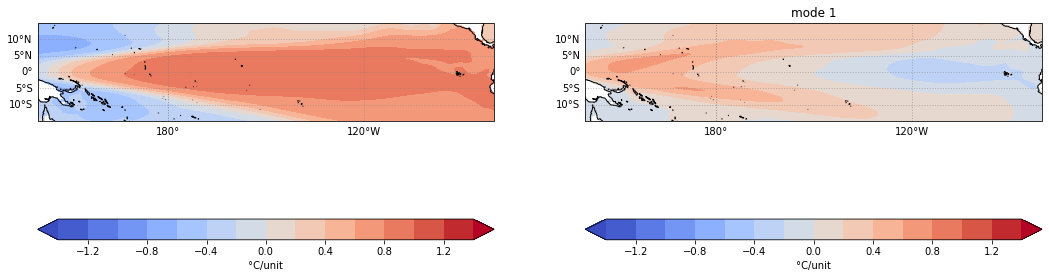

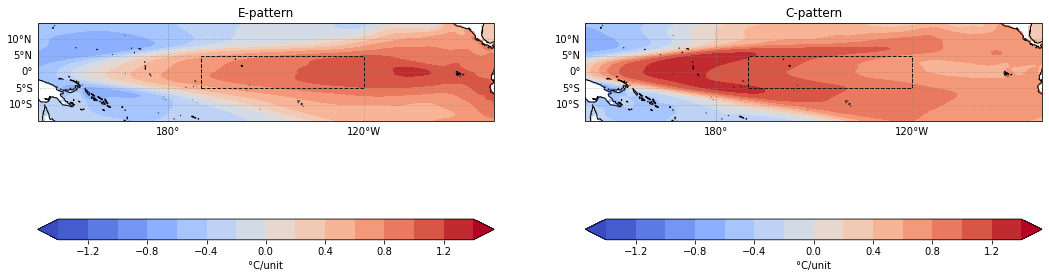

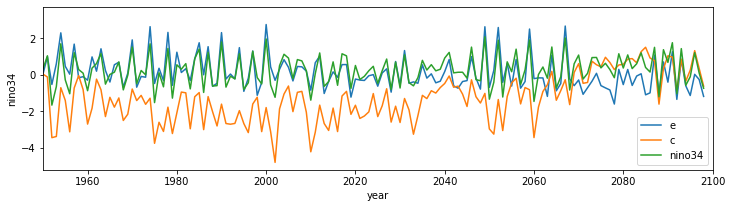

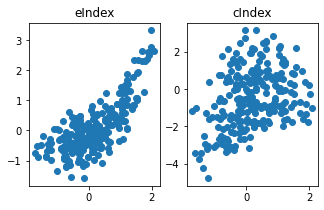

NESM3
[1, -1]


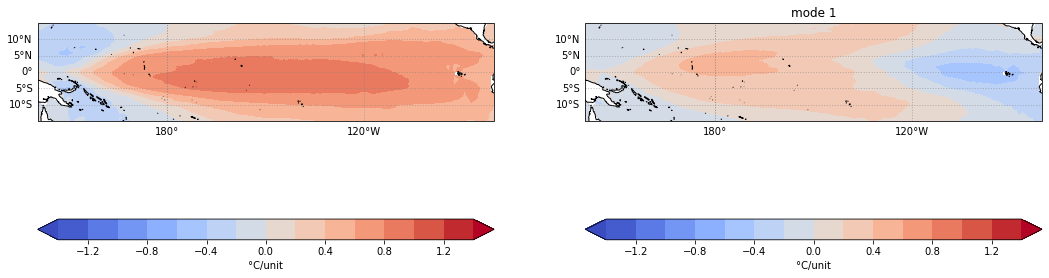

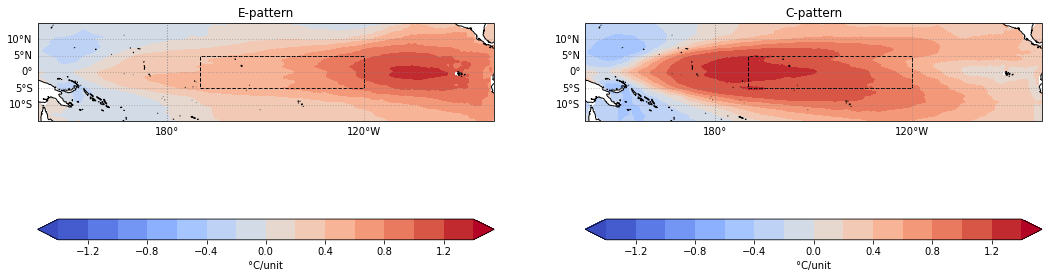

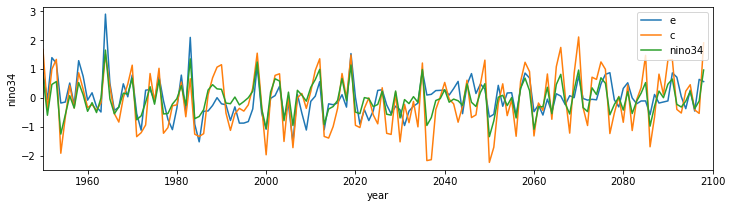

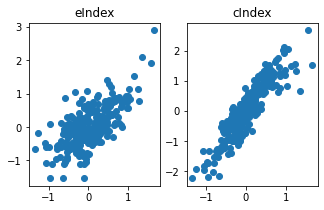

NorESM2-LM
[1, -1]


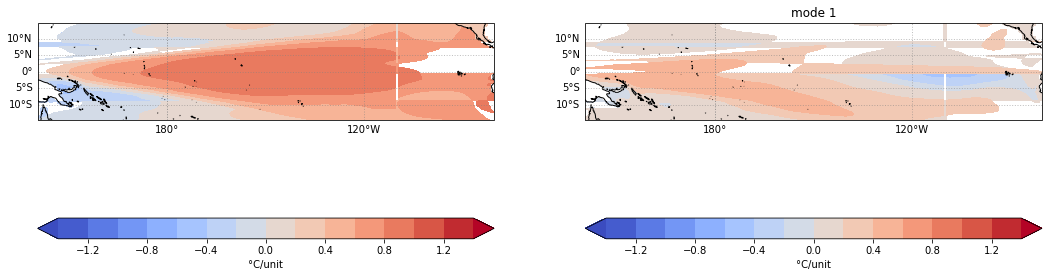

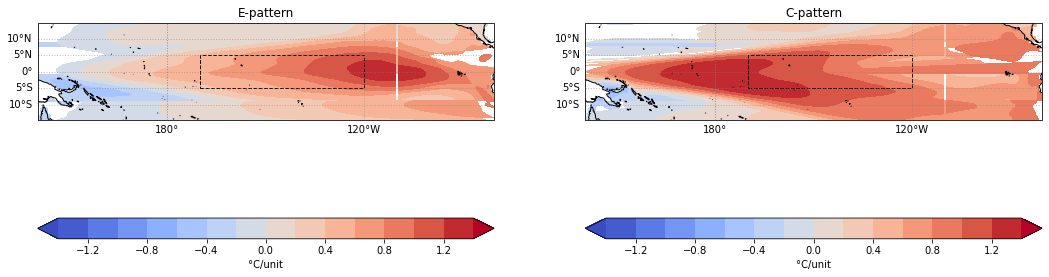

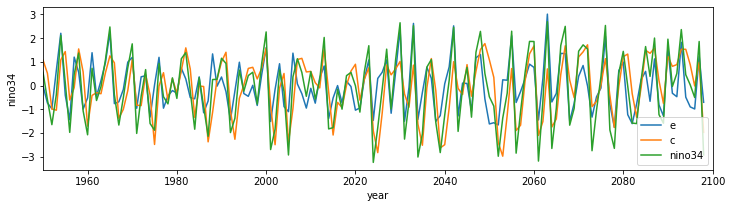

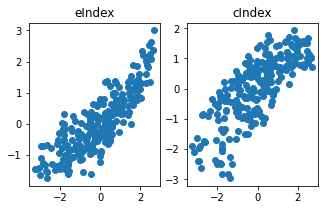

NorESM2-MM
[-1, -1]


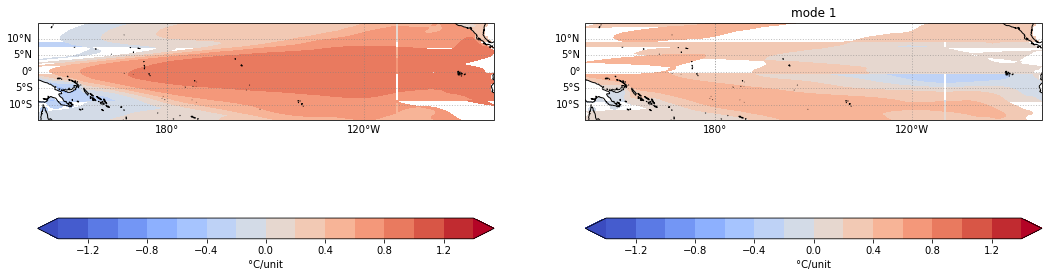

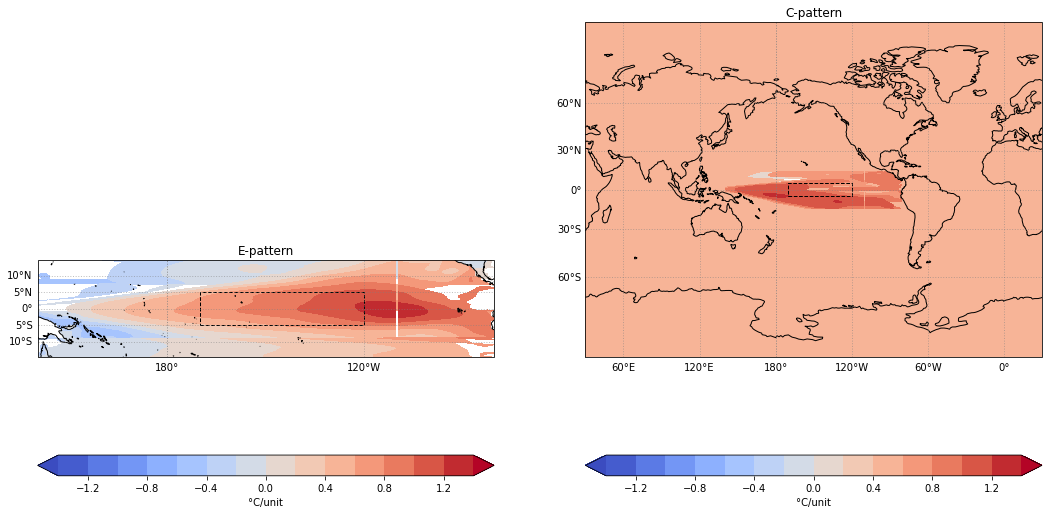

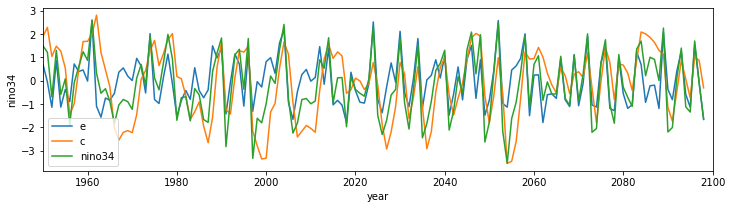

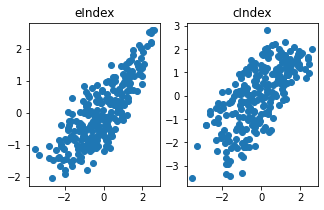

UKESM1-0-LL
[-1, -1]


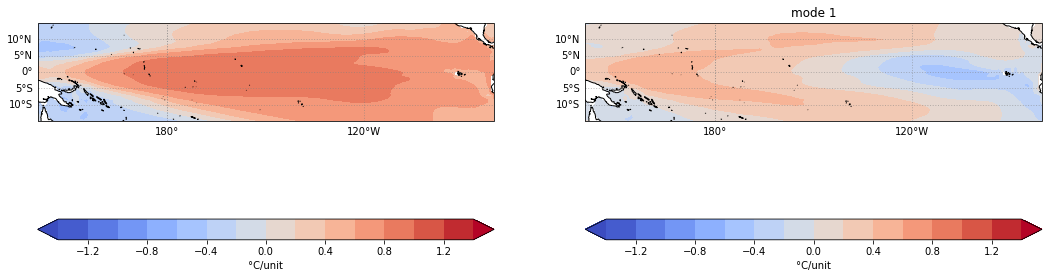

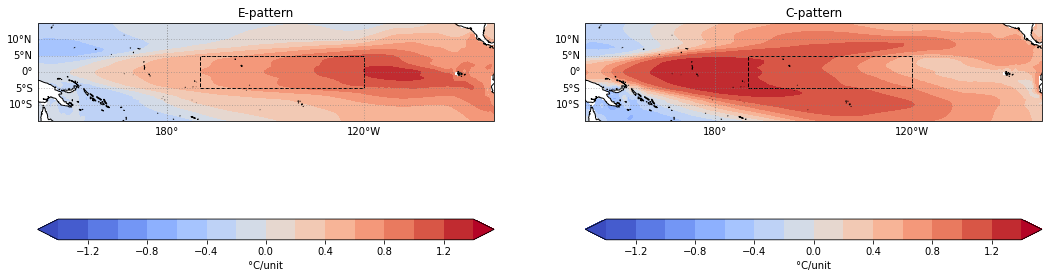

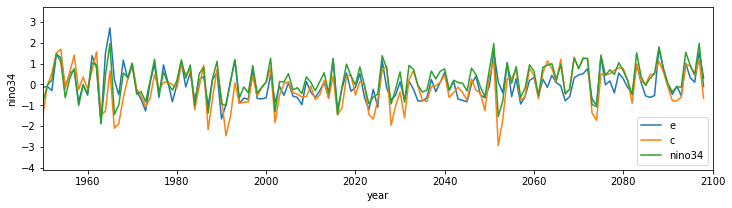

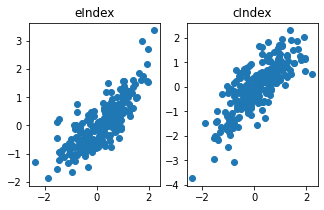

In [10]:
#somewhere to store results
allWarmSeasLs=list()

#for all models
for iModel in _model.scenarioMip[:,1]:
    try:
        print(iModel)
        multiplyBy=multipliers[iModel]
        print(multiplyBy)
        
        eofsXr=xarray.open_dataarray('results/cmipEcIndex/eof'+iModel+'.nc')
        
        #Open experiment results
        piConXr = xarray.open_dataset('results/cmipEcIndex/pcPiControl' + iModel + '.nc')
        
        expXr = xarray.open_dataset('results/cmipEcIndex/pcssp585' + iModel + '.nc')
        
        #merge into one Xr
        pcXr=xarray.concat([piConXr, expXr], 
                           dim='experiment', 
                           data_vars=['pc1','pc2'])
        pcXr['experiment']=['piControl','ssp585']
        
        #normalise using piControl as baseline
        std=piConXr.std()
        pcXr=pcXr/std
        
        #Calc e and c
        indexXr=xarray.Dataset()
        indexXr['eIndex']=(multiplyBy[0]*pcXr.pc1-multiplyBy[1]*pcXr.pc2)/numpy.sqrt(2)
        indexXr['cIndex']=(multiplyBy[0]*pcXr.pc1+multiplyBy[1]*pcXr.pc2)/numpy.sqrt(2)
        indexXr['model']=iModel
          
        #Average over warmseason and store
        allWarmSeasXr=tp.averageForTimePeriod(indexXr)
        allWarmSeasXr['model']=iModel
        allWarmSeasLs.append(allWarmSeasXr)
            
        #some data to plot
        warmSeasXr=allWarmSeasXr.sel(
            experiment='ssp585',year=range(1850,2099),drop=True)
        
        #some maps
        try:
            #first plots of pc1 and pc2
            fig=plt.figure(figsize=(18,12))
            for mode in [0,1]:
                ax=fig.add_subplot(1,2,mode+1,
                               projection=ccrs.Miller(central_longitude=210))
                ec.ensoPlotter(
                    multiplyBy[mode]*eofsXr.sel(mode=mode), ax)
            plt.title("mode " + str(mode))
            plt.show()

            #then plots of e pattern and c pattern
            fig=plt.figure(figsize=(18,12))
            ax=fig.add_subplot(1,2,1,
                           projection=ccrs.Miller(central_longitude=210))
            ec.ensoPlotter(
                multiplyBy[0]*eofsXr.sel(mode=0)-multiplyBy[1]*eofsXr.sel(mode=1),
                ax)
            ax.add_patch(mpatches.Rectangle(
                xy=nino34Box['xy'], 
                width=nino34Box['width'], 
                height=nino34Box['height'],
                edgecolor='black',facecolor='none', linestyle='dashed'))
            plt.title("E-pattern")

            ax=fig.add_subplot(1,2,2,
                           projection=ccrs.Miller(central_longitude=210))
            ec.ensoPlotter(multiplyBy[0]*eofsXr.sel(mode=0)+multiplyBy[1]*eofsXr.sel(mode=1), ax)
            ax.add_patch(mpatches.Rectangle(
                xy=nino34Box['xy'], 
                width=nino34Box['width'], 
                height=nino34Box['height'],
                edgecolor='black',facecolor='none', linestyle='dashed'))
            plt.title("C-pattern")
            plt.show()
            
        except Exception as e:
            print('Cannot print patterns')
            print(e)
            
        #comparisons of e and c index to nino34
        tradIndexXr = xarray.open_dataset(
            '../compound/results/cmipWarmSeasonIndeces/'+iModel+'tosssp585.nc'
        ).sel(year=range(1850,2099))
        
        #plot vs time
        fig = plt.figure(figsize=(12,3))
        warmSeasXr.eIndex.plot()
        warmSeasXr.cIndex.plot()
        tradIndexXr.nino34.plot()

        
        plt.xlim([1950,2100])
        plt.legend(['e','c','nino34'])
        plt.show()
            
        #scatter plots
        fig = plt.figure(figsize=(8,3))

        plt.subplot(1,3,1)
        plt.scatter(tradIndexXr.nino34, warmSeasXr.eIndex)
        plt.title('eIndex')
        
        plt.subplot(1,3,2)
        plt.scatter(tradIndexXr.nino34, warmSeasXr.cIndex)
        plt.title('cIndex')

        plt.show()

    except Exception as e:
        print('skipping' + iModel ) 
        print(e)
    
#save the answers
ecXr=xarray.concat(allWarmSeasLs,'model').to_netcdf('results/cmip6EcIndex.nc')